In [1]:
import sys
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import sqrt
import pickle
import scipy
from scipy.linalg import sqrtm, inv

sys.path.insert(1, '../../methods')
from TriangularEstimators import ScaledCostOT

np.random.seed(42069)

In [2]:
def SigmaCholeskySigma(d):
    if d == 2:
        Aprime = np.random.randn(d,d)
        Sigma = Aprime @ Aprime.T
        LSigma = scipy.linalg.cholesky(Sigma,lower=True).T
    elif d > 2:
        Aprime = np.random.randn(d//2,d//2)
        Bprime = np.random.randn(d//2,d//2)
        SigmaX = Aprime @ Aprime.T

        G = np.random.randn(d//2,d//2)

        A = SigmaX
        B = G@SigmaX
        Bt = B.T
        D = G@SigmaX@G.T + np.eye(d//2)*0.01
        Sigma = np.zeros((d,d))
        Sigma[0:d//2,0:d//2] = A
        Sigma[0:d//2,-d//2:] = Bt
        Sigma[-d//2:,0:d//2] = B
        Sigma[-d//2:,-d//2:] = D
        ##############################
        ##############################
        ##############################
        S = D - B @inv(A) @ Bt

        LA = sqrtm(A)
        LS = sqrtm(S)
        LSigma = np.zeros((d,d))
        LSigma[0:d//2,0:d//2] = LA
        LSigma[0:d//2,-d//2:] = inv(LA)@Bt
        LSigma[-d//2:,-d//2:] = LS

    return Sigma, LSigma.T

In [3]:
# define problem
d = 4
Sigma, LSigma = SigmaCholeskySigma(d)
dim_x = dim_y = d // 2

# define number of samples
Nsamples = np.logspace(3,4,7,dtype=int)
Nmc = 10000
n_trials = 5

n_methods = ['ICNN','NN','OTT']

## for NN
n_iters_icnn = 5000
hidden_dim_icnn = 128
batch_size_icnn = 256

## for OTT method
n_inters_ott = 5000
beta_scaling = 1

# define array to store results
L2_dict = {method: np.zeros((n_trials, len(Nsamples))) for method in n_methods}

# define test data
X_mc = np.random.randn(Nmc,d)
chol_map = (LSigma @ X_mc.T).T

In [6]:
for j,n in enumerate(Nsamples):
    print('n:',n)
    
    # set eps and beta
    beta = 0.1/(n**(1./5))
    eps  = beta**2 / beta_scaling

    for i in range(n_trials):
        print('trial:',i)
        
        # generate training data
        X_source = np.random.randn(n,d)
        source_ = np.random.randn(n,d)
        X_target = (sqrtm(Sigma) @ source_.T).T

        ## ICNN model
        # ot_icnn = ScaledCostOT(dx1=dim_x,dx2=dim_y,beta=beta,estimator='ICNN',
        #                        n_iters=n_iters_icnn,hidden_dim=hidden_dim_icnn,
        #                       batch_size=batch_size_icnn) ## move this as a **args
        # ot_icnn.fit(source=X_source, target=X_target)
        # print('Done ICNN')

        ## Nearest-Neighbor estimator
        ot_nn = ScaledCostOT(dx1=dim_x,dx2=dim_y,beta=beta,estimator='NN')
        ot_nn.fit(source=X_source, target=X_target)
        print('Done NN')

        ## Entropic map estimator
        ot_ott = ScaledCostOT(dx1=dim_x,dx2=dim_y,beta=beta,estimator='OTT',eps=eps)
        ot_ott.fit(source=X_source, target=X_target, max_iter=n_inters_ott)
        print('Done OTT')

        # YX_transp_icnn = np.array(ot_icnn.evaluate(X_mc.copy()))
        # L2_dict['ICNN'][i,j,k] = (np.linalg.norm(YX_transp_icnn - chol_map,ord=2,axis=-1)**2).mean()

        YX_transp_nn = np.array(ot_nn.evaluate(X_mc.copy()))
        L2_dict['NN'][i,j] = (np.linalg.norm(YX_transp_nn - chol_map,ord=2,axis=-1)**2).mean()

        YX_transp_ott = np.array(ot_ott.evaluate(X_mc.copy()))
        L2_dict['OTT'][i,j] = (np.linalg.norm(YX_transp_ott - chol_map,ord=2,axis=-1)**2).mean()


all_info = {'L2_dict': L2_dict, 'LSigma':LSigma, 'Sigma':Sigma, 'n_samples':Nsamples, 'Nmc':Nmc,
            'beta_scaling':beta_scaling, 'n_inters_ott': n_inters_ott}

with open('CholeskyMap_learning.pkl', 'wb') as handle:
    pickle.dump(all_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

n: 1000
trial: 0
Done NN
Done OTT
trial: 1
Done NN
Done OTT
trial: 2
Done NN
Done OTT
trial: 3
Done NN
Done OTT
trial: 4
Done NN
Done OTT
n: 1467
trial: 0
Done NN
Done OTT
trial: 1
Done NN
Done OTT
trial: 2
Done NN
Done OTT
trial: 3
Done NN
Done OTT
trial: 4
Done NN
Done OTT
n: 2154
trial: 0
Done NN
Done OTT
trial: 1
Done NN
Done OTT
trial: 2
Done NN
Done OTT
trial: 3
Done NN
Done OTT
trial: 4
Done NN
Done OTT
n: 3162
trial: 0
Done NN
Done OTT
trial: 1
Done NN
Done OTT
trial: 2
Done NN
Done OTT
trial: 3
Done NN
Done OTT
trial: 4
Done NN
Done OTT
n: 4641
trial: 0
Done NN
Done OTT
trial: 1
Done NN
Done OTT
trial: 2
Done NN
Done OTT
trial: 3
Done NN
Done OTT
trial: 4
Done NN
Done OTT
n: 6812
trial: 0
Done NN
Done OTT
trial: 1
Done NN
Done OTT
trial: 2
Done NN
Done OTT
trial: 3
Done NN
Done OTT
trial: 4
Done NN
Done OTT
n: 10000
trial: 0
Done NN
Done OTT
trial: 1
Done NN
Done OTT
trial: 2
Done NN
Done OTT
trial: 3
Done NN
Done OTT
trial: 4
Done NN
Done OTT


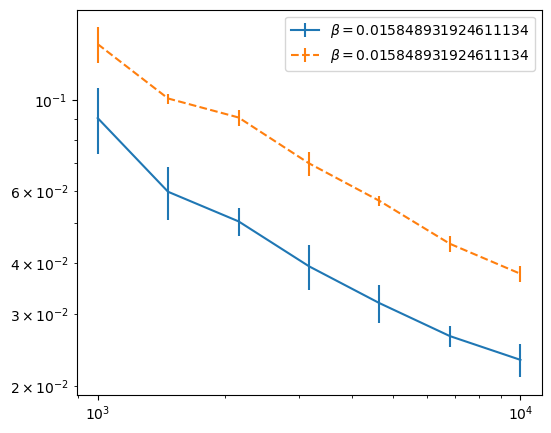

In [7]:
ott_vals_inc = all_info['L2_dict']['OTT']
nn_vals_inc = all_info['L2_dict']['NN']

plt.figure(figsize=(6,5))

ott_vals_k_mean = np.mean(ott_vals_inc,axis=0)
ott_vals_k_std = np.std(ott_vals_inc,axis=0)

nn_vals_k_mean = np.mean(nn_vals_inc,axis=0)
nn_vals_k_std = np.std(nn_vals_inc,axis=0)


plt.errorbar(Nsamples, ott_vals_k_mean,yerr=ott_vals_k_std,label=r'$\beta={}$'.format(beta),linestyle='solid')
plt.errorbar(Nsamples, nn_vals_k_mean,yerr=nn_vals_k_std,label=r'$\beta={}$'.format(beta),linestyle='dashed')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
